# Imports

In [54]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import numpy as np
import mediapipe as mp

from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from IPython.display import Image, display

# File Processing

In [2]:
images =[]
labels = []

dataset_path = './asl_dataset'

for subfolder in os.listdir(dataset_path):
    subfolder_path = os.path.join(dataset_path, subfolder)
    for image_filename in os.listdir(subfolder_path):
        image_path = os.path.join(subfolder_path, image_filename)
        images.append(image_path)
        labels.append(subfolder)

print(f"Loaded {len(images)} files.")

Loaded 28515 files.


In [3]:
df = pd.DataFrame({'image': images, 'label': labels})
df

image label
0      ./asl_dataset\0\hand1_0_bot_seg_1_cropped.jpeg     0
1      ./asl_dataset\0\hand1_0_bot_seg_2_cropped.jpeg     0
2      ./asl_dataset\0\hand1_0_bot_seg_3_cropped.jpeg     0
3      ./asl_dataset\0\hand1_0_bot_seg_4_cropped.jpeg     0
4      ./asl_dataset\0\hand1_0_bot_seg_5_cropped.jpeg     0
...                                               ...   ...
28510  ./asl_dataset\z\hand5_z_dif_seg_1_cropped.jpeg     z
28511  ./asl_dataset\z\hand5_z_dif_seg_2_cropped.jpeg     z
28512  ./asl_dataset\z\hand5_z_dif_seg_3_cropped.jpeg     z
28513  ./asl_dataset\z\hand5_z_dif_seg_4_cropped.jpeg     z
28514  ./asl_dataset\z\hand5_z_dif_seg_5_cropped.jpeg     z

[28515 rows x 2 columns]

In [4]:
df['label'].describe()

count     28515
unique       36
top           i
freq       1070
Name: label, dtype: object

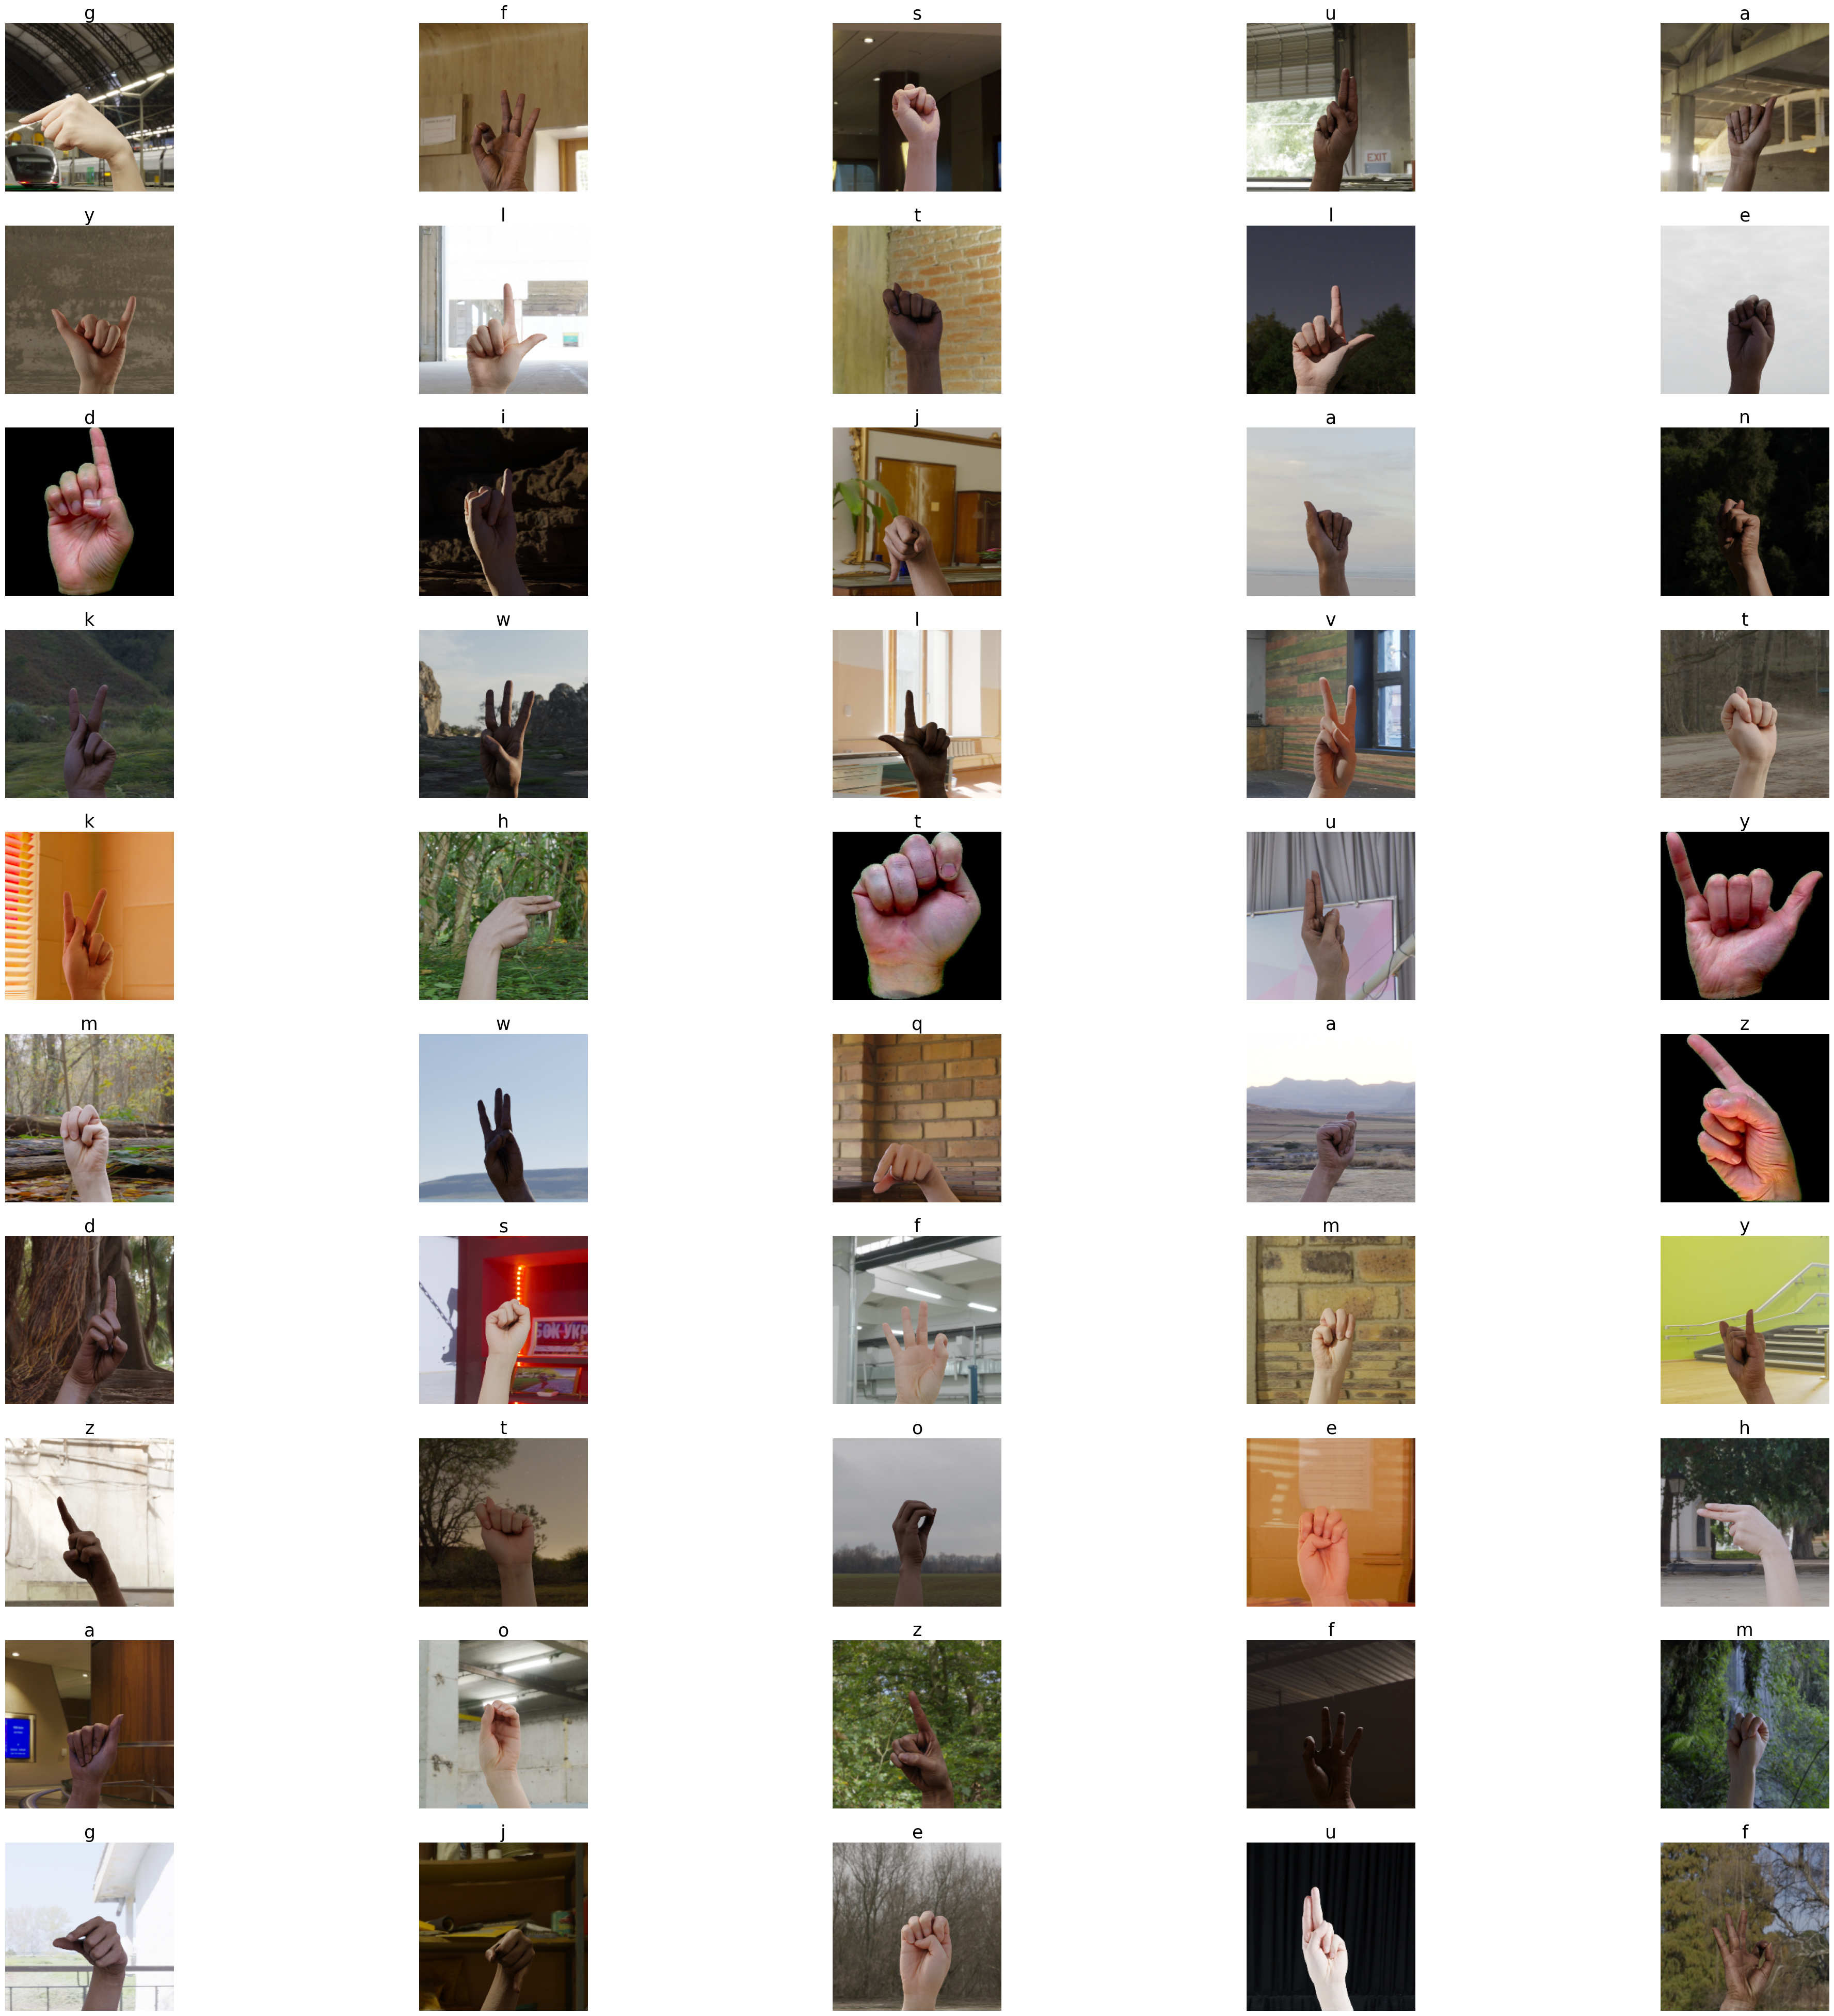

In [5]:
plt.figure(figsize=(50,50))
for n,i in enumerate(np.random.randint(0,len(df),50)):
    plt.subplot(10,5,n+1)
    img=cv2.imread(df.image[i])
    img=cv2.resize(img,(224,224))
    img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.axis('off')
    plt.title(df.label[i],fontsize=25)

# Data Processing

In [6]:
def preprocess_images(image_paths):
    images = []
    for path in image_paths:
        img = cv2.imread(path)
        img = cv2.resize(img, (224, 224))  # Resize to 224x224
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB
        img = img / 255.0  # Normalize pixel values to [0, 1]
        images.append(img)
    return np.array(images)

# Spliting Data



In [7]:
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

In [8]:
train_size = int(0.7 * len(df))  # 70% for training
val_size = int(0.15 * len(df))   # 15% for validation
test_size = len(df) - train_size - val_size  # 15% for testing

In [9]:
train_df = df[:train_size]
val_df = df[train_size:train_size + val_size]
test_df = df[train_size + val_size:]

In [10]:
print(f"Training set size: {len(train_df)}")
print(f"Validation set size: {len(val_df)}")
print(f"Test set size: {len(test_df)}")

Training set size: 19960
Validation set size: 4277
Test set size: 4278


In [11]:
print("Train set label distribution:")
print(train_df['label'].value_counts())

print("Validation set label distribution:")
print(val_df['label'].value_counts())

print("Test set label distribution:")
print(test_df['label'].value_counts())

Train set label distribution:
label
n    786
i    779
h    767
g    764
r    759
c    757
t    756
l    753
a    753
f    749
s    748
q    748
j    748
o    747
k    746
w    745
p    744
b    744
x    742
d    741
z    741
u    740
y    736
e    732
m    730
v    713
6     59
0     55
1     55
4     52
8     50
3     48
7     46
5     46
9     46
2     35
Name: count, dtype: int64
Validation set label distribution:
label
d    176
y    175
m    172
v    170
e    170
q    169
p    168
u    167
j    166
b    166
w    165
l    164
c    163
s    163
a    162
o    160
r    158
n    158
k    155
f    154
h    150
x    149
g    147
t    146
i    140
z    140
2     17
9     14
3     14
7     12
5     10
4     10
8      9
0      7
1      7
6      4
Name: count, dtype: int64
Test set label distribution:
label
z    189
v    187
x    179
k    169
e    168
m    168
f    167
o    163
u    163
t    163
w    160
b    160
g    159
s    159
y    159
p    158
j    156
a    155
q    153
d    153
l    153

# Model

## Prepare Data

In [12]:
# Separate image paths (X) and labels (y)
X_train = train_df['image'].values
y_train = train_df['label'].values

X_val = val_df['image'].values
y_val = val_df['label'].values

X_test = test_df['image'].values
y_test = test_df['label'].values

In [13]:
X_train_processed = preprocess_images(X_train)
X_val_processed = preprocess_images(X_val)
X_test_processed = preprocess_images(X_test)

In [14]:
# one-hot encoding
lb = LabelBinarizer()
y_train_encoded = lb.fit_transform(y_train)
y_val_encoded = lb.transform(y_val)
y_test_encoded = lb.transform(y_test)

In [15]:
# X- (num_samples, height, width, channels-RGB)
# y- (num_samples, num_classes-labels)
print(f"X_train shape: {X_train_processed.shape}")
print(f"y_train shape: {y_train_encoded.shape}")
print(f"X_val shape: {X_val_processed.shape}")
print(f"y_val shape: {y_val_encoded.shape}")
print(f"X_test shape: {X_test_processed.shape}")
print(f"y_test shape: {y_test_encoded.shape}")

X_train shape: (19960, 224, 224, 3)
y_train shape: (19960, 36)
X_val shape: (4277, 224, 224, 3)
y_val shape: (4277, 36)
X_test shape: (4278, 224, 224, 3)
y_test shape: (4278, 36)


## MediaPipe Hands

In [16]:
mp_hands = mp.solutions.hands
mp_drawing = mp.solutions.drawing_utils

hands = mp_hands.Hands(static_image_mode=True, max_num_hands=1, min_detection_confidence=0.5)

In [17]:
def extract_landmarks(image_paths):
    landmarks_list = []
    for path in image_paths:
        img = cv2.imread(path)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB for MediaPipe
        results = hands.process(img_rgb)
        
        if results.multi_hand_landmarks:  # If hand landmarks are detected
            for hand_landmarks in results.multi_hand_landmarks:
                landmarks = []
                for landmark in hand_landmarks.landmark:
                    # Store x, y, z coordinates
                    landmarks.extend([landmark.x, landmark.y, landmark.z])
                landmarks_list.append(landmarks)
        else:
            # Append a zero array if no landmarks are detected
            landmarks_list.append([0] * 63)  # 21 landmarks * 3 (x, y, z)

    return np.array(landmarks_list)

In [18]:
X_train_landmarks = extract_landmarks(X_train)
X_val_landmarks = extract_landmarks(X_val)
X_test_landmarks = extract_landmarks(X_test)

## Neural Network Model

In [29]:
model = Sequential([
    Input(shape=(63,)),              # 63 input features (x, y, z for each landmark)
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(y_train_encoded.shape[1], activation='softmax')  # Output layer with number of classes
])

In [32]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                      │ (None, 128)                 │           8,192 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 36)                  │           2,340 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 18,788 (73.39 KB)

 Trainable params: 18,788 (73.39 KB)

 Non-trainable params: 0 (0.00 B)

In [41]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    X_train_landmarks, y_train_encoded,
    validation_data=(X_val_landmarks, y_val_encoded),
    epochs=50,
    batch_size=32,
    callbacks=[early_stopping]
)

Epoch 1/50
624/624 ━━━━━━━━━━━━━━━━━━━━ 0s 562us/step - accuracy: 0.8401 - loss: 0.5550 - val_accuracy: 0.8597 - val_loss: 0.5115
Epoch 2/50
624/624 ━━━━━━━━━━━━━━━━━━━━ 0s 535us/step - accuracy: 0.8433 - loss: 0.5408 - val_accuracy: 0.8590 - val_loss: 0.5082
Epoch 3/50
624/624 ━━━━━━━━━━━━━━━━━━━━ 0s 535us/step - accuracy: 0.8482 - loss: 0.5300 - val_accuracy: 0.8599 - val_loss: 0.5106
Epoch 4/50
624/624 ━━━━━━━━━━━━━━━━━━━━ 0s 534us/step - accuracy: 0.8385 - loss: 0.5559 - val_accuracy: 0.8585 - val_loss: 0.5157
Epoch 5/50
624/624 ━━━━━━━━━━━━━━━━━━━━ 0s 538us/step - accuracy: 0.8447 - loss: 0.5428 - val_accuracy: 0.8597 - val_loss: 0.5129
Epoch 6/50
624/624 ━━━━━━━━━━━━━━━━━━━━ 0s 533us/step - accuracy: 0.8464 - loss: 0.5408 - val_accuracy: 0.8621 - val_loss: 0.5045
Epoch 7/50
624/624 ━━━━━━━━━━━━━━━━━━━━ 0s 534us/step - accuracy: 0.8447 - loss: 0.5375 - val_accuracy: 0.8592 - val_loss: 0.5121
Epoch 8/50
624/624 ━━━━━━━━━━━━━━━━━━━━ 0s 543us/step - accuracy: 0.8425 - loss: 0.5452 - 

# Evaluate

In [42]:
test_loss, test_accuracy = model.evaluate(X_test_landmarks, y_test_encoded)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 333us/step - accuracy: 0.8646 - loss: 0.5048
Test Accuracy: 86.21%


# Visualize

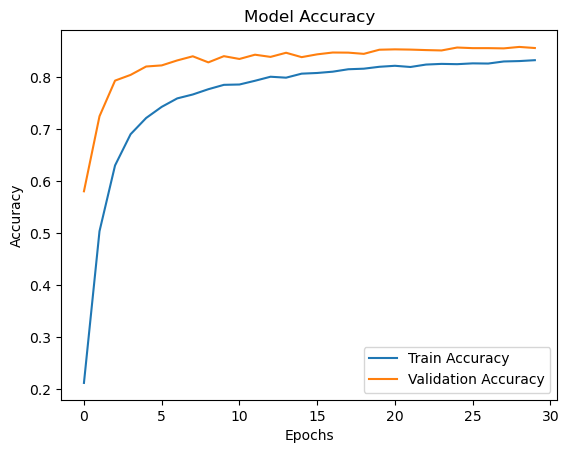

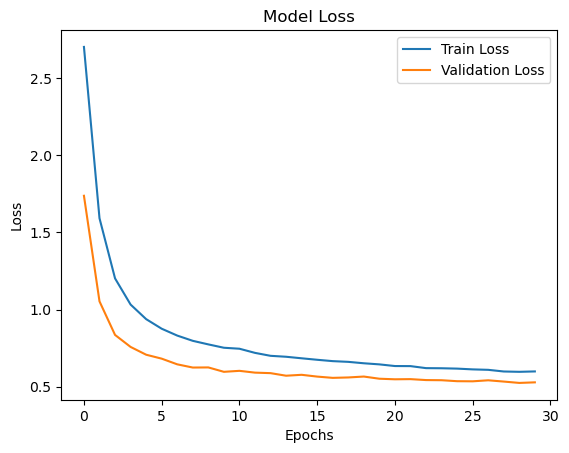

In [34]:
# Plot accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Save Model 

In [53]:
model.save('asl_model.keras')